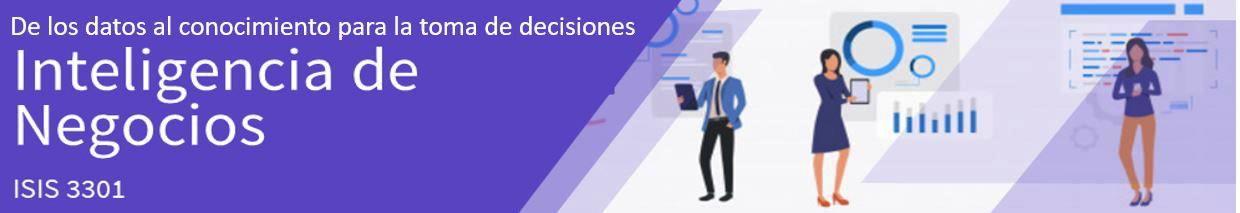

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

In [1]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaistamaio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Función para tokenizar las reseñas de hotel
def tokenizer(text):
    return word_tokenize(text)

### Loading tweets

In [5]:
tweets_df = pd.read_csv('./data/MovieReviews.csv', sep = ',')

In [6]:
tweets_df.shape

(5000, 3)

In [7]:
tweets_df.sample(5)

,Unnamed: 0,review_es,sentimiento
111,111,"Está bien, ese fue un buen maldito episodio.Mucho mejor que el crédito que recibe. El trabajo de la cámara es espléndido.Mejor todavía.Me encanta ese tiro final.El ambiente es fantástico, los disfraces son excelentes y el elenco de invitados (menos las víctimas indefensas) es fuerte.Lo que no me gusta de este episodio es que muchas cosas que quedan sin explicación.¿Por qué cambia el sexo?¿Cuál es el propósito?y son alienígenas?¿que tipo?¿Por qué nunca se mostraron de nuevo en la mitología posterior? Estoy dando a este episodio a tres estrellas.Uno de mis favoritos todavía, pero los agujeros de la trama me molestan.Todavía ... no voy a dejar que arruinara mi entretenimiento.",positivo
4514,4514,"I can't remember the worst film I have watchedTotal waste of actors and audience timeIf you prefer sitting by your TV and think when will be this film over,then this is the right film for youMaybe this film is recorded to make people believe that Moscow has some mystique past But I must say I have not expect anything else from Rade Serbedzija,but I have expected more from Vincent GalloThe film lacks a plot, character,development,denouementEntire movie is about underground tunnels and how they are mystiqueI must be fair there is some camera effect but even that is too poorOver and over are the same picturesTotal waste of time",negativo
904,904,"Siempre me siento extraño y culpable, diciéndolo (porque soy un no adolescente bastante bien educado), pero en realidad me gustaría a los gemelos de Olsen, y respeto las películas que hacen, aunque nunca he sido su Público objetivo. ""Cuando en Roma"" fue una película tradicional Mary-Kate y Ashley, completa con los viajes extranjeros, acentos, motos, romance para adultos como una historia ""B"", orientación a la moda e incluso la molestia de la gag sobre los créditos. Lo disfruto yo mismo. ""Cuando en Roma"" y las otras películas de Olsen Twin nunca pretenden ser algo que no lo son; La mayoría de las veces, solo se estrenan en video, y nunca dicen ser el próximo ""Citizen Kane"" o incluso ""un asunto para recordar"". Mi punto es, las personas que ven esta película y esperan que sea algo más que otra película de Olsen Twin se decepcionará. Dicho esto, aquellos que son fanáticos de los gemelos de Olsen realmente se divertirán. Para aquellos de nosotros que los he observado desde los primeros episodios de ""Casa llena"", es realmente genial verlos crecer en papeles más maduros. Esta película proporciona información histórica y geográfica importante, al igual que muchas de sus otras películas (recuerde 10 Downing Street de ""Ganning London"" y la visita al Louvre de ""Pasaporte a París"", así como proporcionar una diversión buena y limpia que pueda Sé disfrutado por toda la familia. Mientras aún me siento como si estuviera en mi caja de jabón, y siempre y cuando pueda hacerlo relevante para la película, déjame tomarme un momento para desafiar a los que rechazan a los gemelos de Olsen: en orden Para ser un fanático de los gemelos de Olsen, no tiene que ser un pre-adolescente ""Chica Valley"" de California. De hecho, esa no es realmente la audiencia objetivo. Si fuera, la línea MK y una línea de moda de ropa y accesorios se realizaría a través de la brecha o una tienda como esa, no Wal-Mart. ""Cuando en Roma"", mientras que cuenta con la ""moda alta"" y la trotación de globo y dos niñas de un valle en Cali, no se trata realmente de eso ... se trata más de inspirar a las chicas jóvenes que tienen iniciativa para que lo lleven. lugares. Si eso significa establecer la película en alguna glamurosa ciudad extranjera con chicos lindos en las motos, así que sé. Eso se llama marketing: te tomas una idea y lo vendas haciéndolo atractivo. Al menos están enviando un buen mensaje, incluso si los medios parecen un poco superficiales. Básicamente, no golpee la película hasta que lo hayas visto, y luego no lo golpees hasta que haya intentado entender lo que hacen los gemelos

In [8]:
tweets_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

### Filtrando los tweets que aún no han sido etiquetados

In [9]:
tweets_sentimientoed_df = tweets_df.loc[tweets_df['sentimiento'].notnull()]

In [10]:
# Tweets a ser usados para entrenar y evaluar el modelo
tweets_sentimientoed_df.shape

(5000, 3)

In [11]:
# Tweets descartados debido a que no se encuentran etiquetados
tweets_df.loc[tweets_df['sentimiento'].isnull()].shape

(0, 3)

In [12]:
# Scenario 1: Treating neutral as positive classes
#tweets_sentimientoed_df['sentimiento'] = tweets_sentimientoed_df['sentimiento'].replace({'neutral': 'positive'})

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_sentimientoed_df = tweets_sentimientoed_df.loc[tweets_sentimientoed_df['sentimiento'].isin(['positive', 'negative'])]

# Scenario 3: Working with all classes

In [13]:
tweets_sentimientoed_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

### Diviendo los tweets etiquetados en los conjuntos de entrenamiento y prueba

In [14]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(tweets_sentimientoed_df['review_es'], tweets_sentimientoed_df['sentimiento'], test_size = 0.2, stratify = tweets_sentimientoed_df['sentimiento'], random_state = 1)

In [15]:
X_train.shape

(4000,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negativo    0.5
positivo    0.5
Name: sentimiento, dtype: float64

In [17]:
X_test.shape

(1000,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negativo    0.5
positivo    0.5
Name: sentimiento, dtype: float64

### Vectorizando los tweets

In [19]:
bow = CountVectorizer(tokenizer=tokenizer, stop_words=list(stop_words), lowercase=True)

In [20]:
X_bow = bow.fit_transform(X_train)

In [21]:
len(bow.vocabulary_)

63059

In [22]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [23]:
X_tfidf = tfidf.fit_transform(X_train)

In [24]:
len(tfidf.vocabulary_)

63059

### Entrenando y evaluando un modelo usado BoW

In [25]:
bow_model = RandomForestClassifier(random_state = 3)

In [26]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot:>

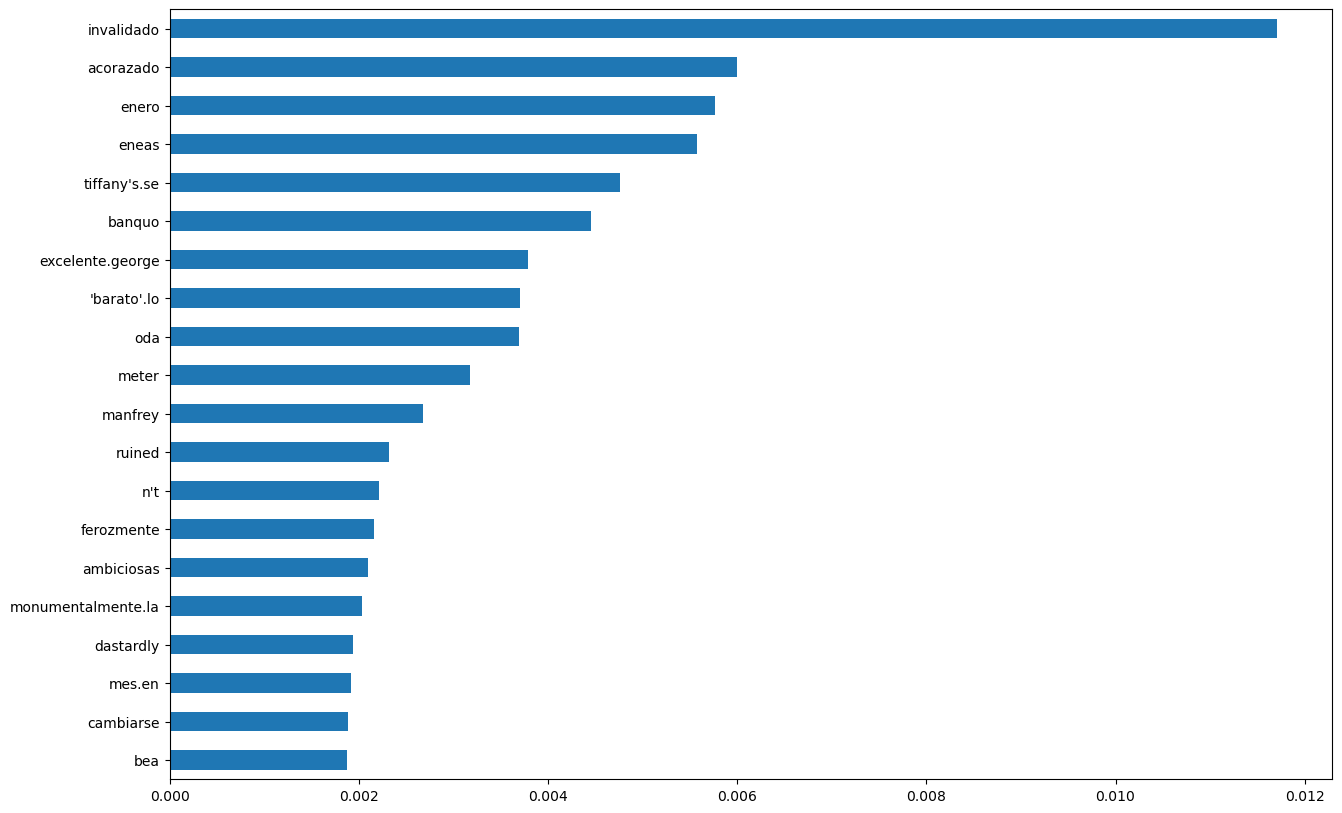

In [27]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [28]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 191.04


In [29]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

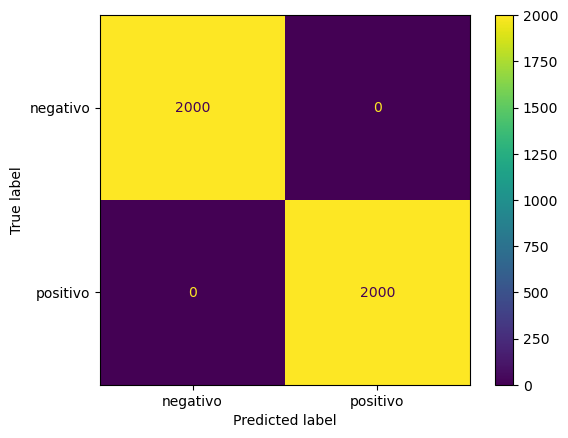

In [30]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

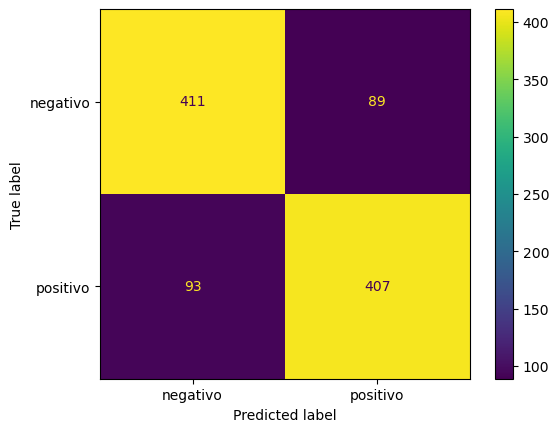

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [32]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [33]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8205645161290323
Recall: 0.814
F1: 0.8172690763052209


### Entrenando y evaluando un modelo usado TF-IDF

In [34]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [35]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot:>

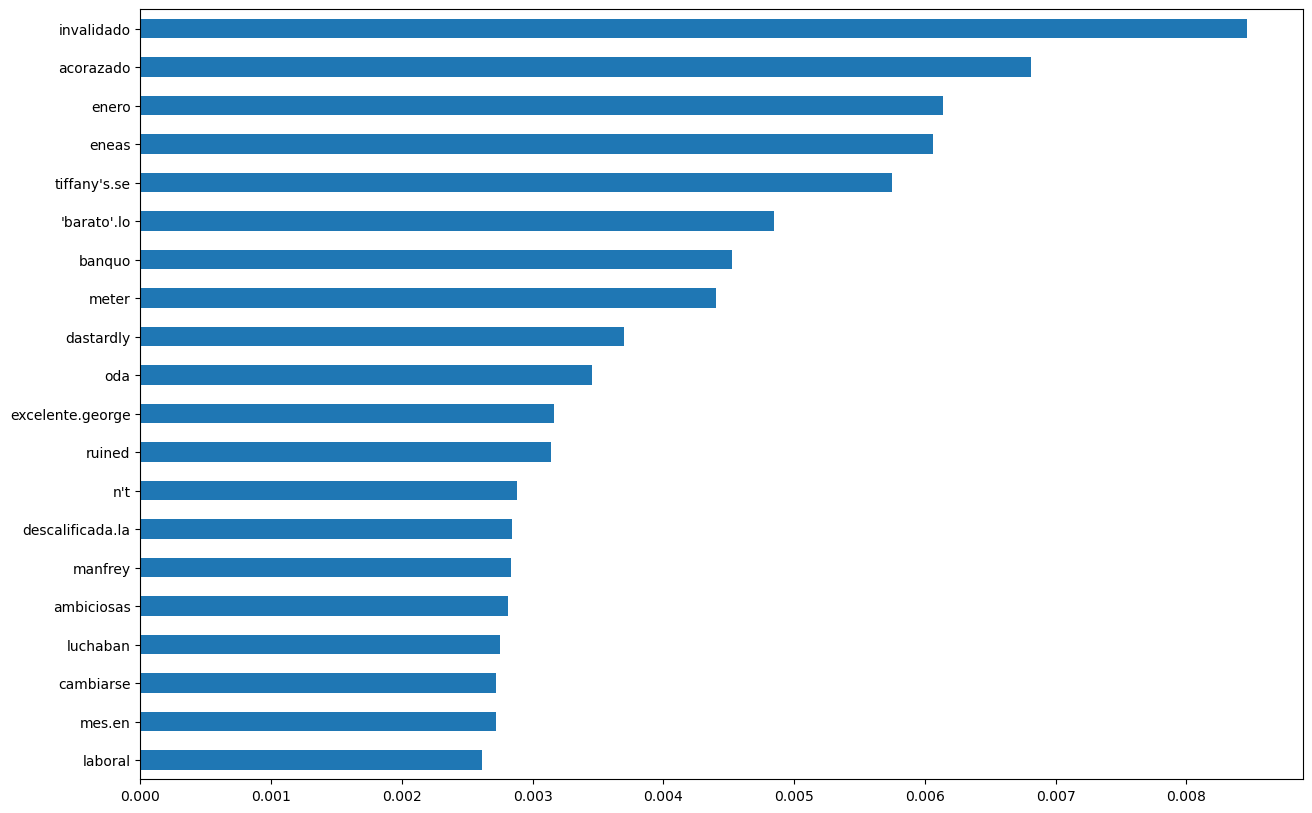

In [36]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [37]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 173.92


In [38]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

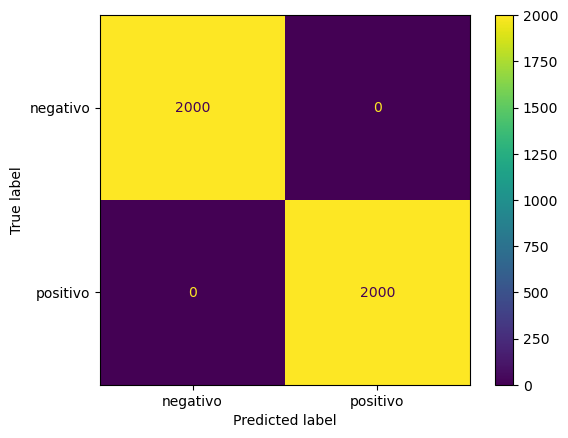

In [39]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

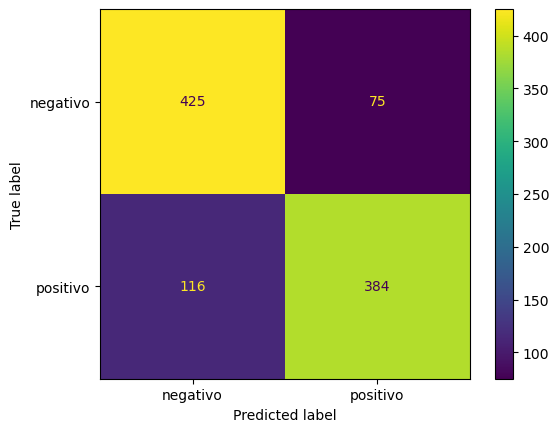

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [41]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [42]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.8366013071895425
Recall: 0.768
F1: 0.8008342022940563


### Entrenando y evaluando un modelo usado HashingVectorizer

In [43]:
hash_vectorizer = HashingVectorizer(n_features=2**16)

In [44]:
X_hash = hash_vectorizer.fit_transform(X_train)
hash_model = RandomForestClassifier(random_state = 2)
hash_model.fit(X_hash, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

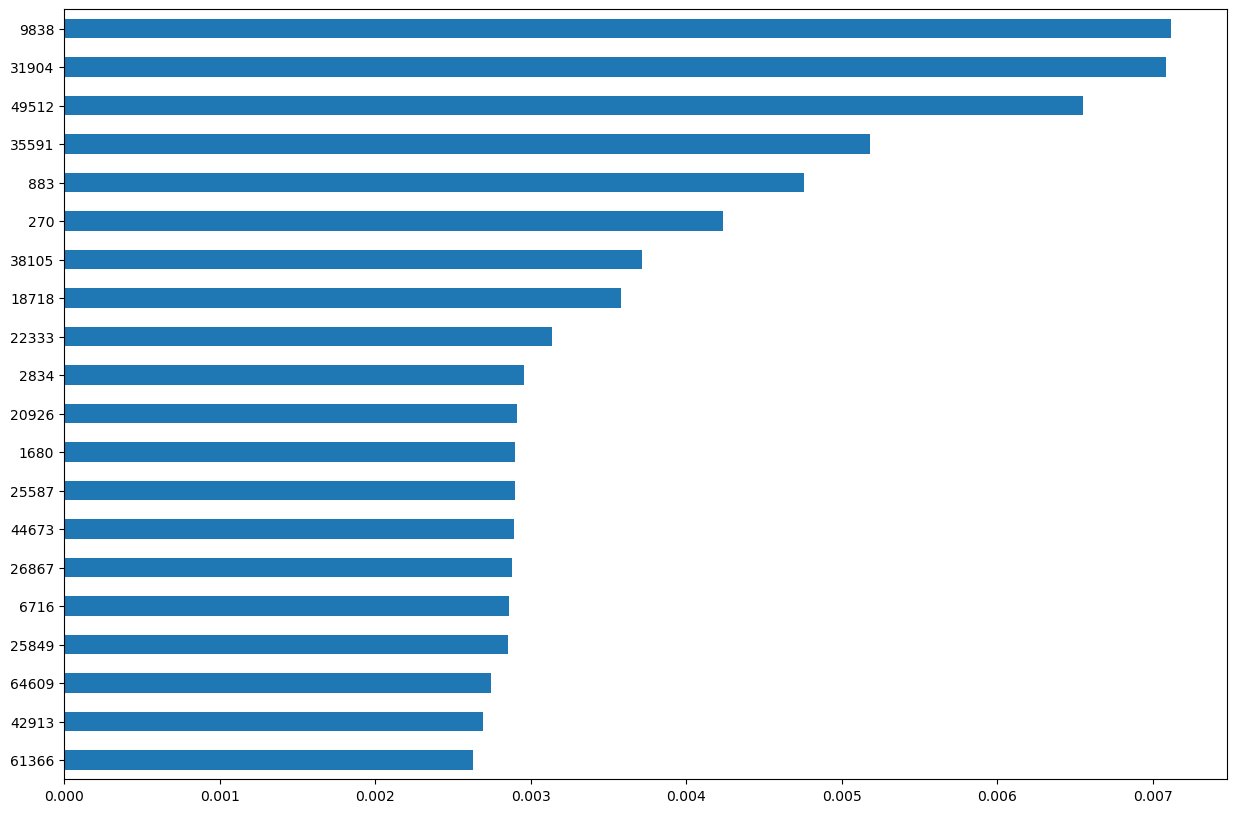

In [45]:
pd.Series(hash_model.feature_importances_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [46]:
hash_estimators = hash_model.estimators_
print('Number of trees:', len(hash_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in hash_estimators]))

Number of trees: 100
Trees depth (mean): 119.96


In [47]:
y_train_hash_predict = hash_model.predict(X_hash)
y_test_hash_predict = hash_model.predict(hash_vectorizer.transform(X_test))

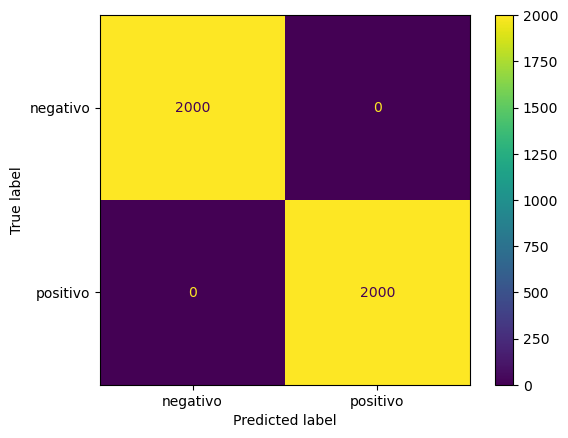

In [48]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_hash_predict)

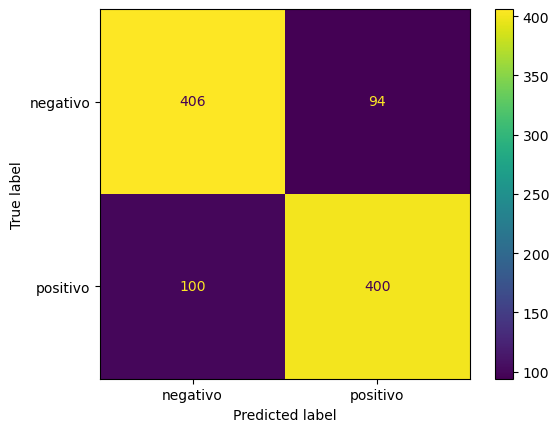

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hash_predict)

In [50]:
if len(hash_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_hash_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_train, y_train_hash_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_train, y_train_hash_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_hash_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_hash_predict, average = None))
    print('F1:', f1_score(y_train, y_train_hash_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [51]:
if len(hash_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_hash_predict, pos_label = 'positivo'))
    print('Recall:', recall_score(y_test, y_test_hash_predict, pos_label = 'positivo'))
    print('F1:', f1_score(y_test, y_test_hash_predict, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_hash_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_hash_predict, average = None))
    print('F1:', f1_score(y_test, y_test_hash_predict, average = None))

Precision: 0.8097165991902834
Recall: 0.8
F1: 0.8048289738430584


### Análisis del error

In [52]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [53]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(191, 3)

In [54]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

review_es  \
632                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Caray, como un hombre gay que vive en Nueva York, puedo decir con gratitud que nunca he visto a la parte inferior de la cultura gay que se representa en esta película, ¡y me alegro de eso!¿Se transmitió esta película en televisión a través de los Estados Unidos, habría una gran reacción anti-gay y no puedo decir que los culparía.Las personas en esta película no representan el promedio de América gay o incluso el Trandgender Americano promedio, lo que sí representan es una pesadilla pura y absoluta.La inclusión de los personajes obviamente menores de edad es espantosa y los sentimientos racistas obvios (anti-blanco) son descarados e inquietant